In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertModel
import re
import glob

In [3]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load dataset
df = pd.read_csv('/kaggle/input/multilingual-datasets/final_datasets.csv')
print(f"Dataset loaded with shape: {df.shape}")

# Image directory
image_dir = "/kaggle/input/multilingual-meme-datasets/datasets/datasets"

Using device: cuda:0
Dataset loaded with shape: (25600, 11)


In [5]:
def create_image_mapping(dataframe, image_directory):
    """
    Create a mapping between dataset 'name' column and actual image filenames in the directory.
    This handles the case where image filenames might have different formats.
    """
    # Get all image files in the directory
    image_files = glob.glob(os.path.join(image_directory, '*'))
    image_mapping = {}
    
    # Create a set of all available image filenames (without path)
    available_images = {os.path.basename(f) for f in image_files}
    print(f"Found {len(available_images)} images in directory")
    
    # Print some sample images to understand the naming pattern
    print("Sample image filenames:", list(available_images)[:5])
    
    # Print some sample names from the dataset
    print("Sample names from dataset:", dataframe['name'].iloc[:5].tolist())
    
    # Method 1: Exact match
    for name in dataframe['name'].unique():
        if name in available_images:
            image_mapping[name] = name
    
    # Method 2: Check if the id is part of the filename
    unmapped_names = set(dataframe['name']) - set(image_mapping.keys())
    for name in unmapped_names:
        # Extract ID from name (assuming name has some ID pattern)
        id_match = re.search(r'\d+', name)
        if id_match:
            id_value = id_match.group()
            # Look for files containing this ID
            matching_files = [f for f in available_images if id_value in f]
            if matching_files:
                image_mapping[name] = matching_files[0]
    
    # Method 3: Try matching using 'ids' or 'id' column if available
    if 'ids' in dataframe.columns or 'id' in dataframe.columns:
        id_col = 'ids' if 'ids' in dataframe.columns else 'id'
        id_to_name = dict(zip(dataframe[id_col], dataframe['name']))
        
        for id_value, name in id_to_name.items():
            if name not in image_mapping:
                # Look for files containing this ID
                matching_files = [f for f in available_images if str(id_value) in f]
                if matching_files:
                    image_mapping[name] = matching_files[0]
    
    print(f"Successfully mapped {len(image_mapping)} out of {len(dataframe['name'].unique())} unique names")
    return image_mapping

In [6]:
# Custom dataset class with image mapping for ResNet50
class HarmfulContentDataset(Dataset):
    def __init__(self, dataframe, image_dir, tokenizer, image_mapping=None, max_len=128):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.image_mapping = image_mapping or {}
        
        # Create a default blank image to use when an image is not found
        self.blank_image = Image.new('RGB', (224, 224), color='white')
        
        # Image transformation for ResNet50
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        
        # Text features
        text_features = f"{row['gender']} {row['age']} {row['age_bucket']} {row['dominant_emotion']} {row['dominant_race']} {row['translated_text']}"
        
        # Tokenize text
        encoding = self.tokenizer.encode_plus(
            text_features,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        # Image processing
        try:
            # Get the correct image filename using the mapping
            image_filename = self.image_mapping.get(row['name'], row['name'])
            image_path = os.path.join(self.image_dir, image_filename)
            
            # Check if the file exists
            if os.path.exists(image_path):
                image = Image.open(image_path).convert('RGB')
            else:
                # Try alternate approach: check if the file exists with different extensions
                base_name = os.path.splitext(image_path)[0]
                for ext in ['.jpg', '.jpeg', '.png', '.gif']:
                    alt_path = base_name + ext
                    if os.path.exists(alt_path):
                        image = Image.open(alt_path).convert('RGB')
                        break
                else:
                    # If still not found, use blank image
                    image = self.blank_image
                    if idx % 100 == 0:  # Limit logging to avoid flooding
                        print(f"Image not found for {row['name']}, using blank image")
            
            # Apply transformations for ResNet50
            image_tensor = self.transform(image)
            
        except Exception as e:
            if idx % 100 == 0:  # Limit logging
                print(f"Error processing image for {row['name']}: {e}")
            # Create blank image features
            image_tensor = torch.zeros((3, 224, 224))
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'image': image_tensor,
            'labels': torch.tensor(row['label'], dtype=torch.long)
        }

In [7]:
import torch
import torch.nn as nn
from torchvision import models
from transformers import BertModel

class VGG16BertClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super(VGG16BertClassifier, self).__init__()
        
        # Load pretrained VGG16 and use only the feature extractor
        vgg16 = models.vgg16(pretrained=True)
        self.vgg_features = vgg16.features
        self.avgpool = vgg16.avgpool
        
        # Freeze all VGG16 parameters
        for param in self.vgg_features.parameters():
            param.requires_grad = False
        
        # Unfreeze last few layers of VGG16 for fine-tuning
        for layer in list(self.vgg_features.children())[-4:]:
            for param in layer.parameters():
                param.requires_grad = True
        
        # Load pre-trained BERT
        self.bert = BertModel.from_pretrained("bert-base-multilingual-cased")
        
        # Freeze all BERT parameters
        for param in self.bert.parameters():
            param.requires_grad = False
        
        # Unfreeze last 2 layers of BERT
        for param in self.bert.encoder.layer[-2:].parameters():
            param.requires_grad = True
        
        # Flatten layer for VGG16 output
        self.flatten = nn.Flatten()
        
        # VGG16 feature output: 512 x 7 x 7 = 25088
        vgg_output_dim = 512 * 7 * 7
        bert_output_dim = self.bert.config.hidden_size  # usually 768
        
        # Combined classifier
        self.classifier = nn.Sequential(
            nn.Linear(vgg_output_dim + bert_output_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, input_ids, attention_mask, image):
        # VGG16 image feature extraction
        image_features = self.vgg_features(image)
        image_features = self.avgpool(image_features)
        image_features = self.flatten(image_features)  # (B, 25088)
        
        # BERT text feature extraction
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        bert_cls_embedding = bert_outputs.last_hidden_state[:, 0, :]  # (B, 768)
        
        # Combine
        combined = torch.cat((image_features, bert_cls_embedding), dim=1)
        logits = self.classifier(combined)
        
        return logits


In [24]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler=None, num_epochs=10):
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []
    
    best_valid_loss = float('inf')
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for batch_idx, batch in enumerate(train_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            labels = batch['labels'].to(device)
            
            optimizer.zero_grad()
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, image=images)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            
            # Print batch progress
            if (batch_idx + 1) % 10 == 0:
                print(f'Epoch {epoch+1}, Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss.item():.4f}')
        
        train_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # Validation
        model.eval()
        running_valid_loss = 0.0
        correct_valid = 0
        total_valid = 0
        
        with torch.no_grad():
            for batch in valid_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                images = batch['image'].to(device)
                labels = batch['labels'].to(device)
                
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, image=images)
                loss = criterion(outputs, labels)
                
                running_valid_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total_valid += labels.size(0)
                correct_valid += (predicted == labels).sum().item()
        
        valid_loss = running_valid_loss / len(valid_loader)
        valid_accuracy = correct_valid / total_valid
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)
        
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
              f'Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_accuracy:.4f}')
        
        # Update scheduler if provided
        if scheduler is not None:
            scheduler.step(valid_loss)
        
        # Save best model
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'best_vgg16_bert_model.pth')
            print(f'Saved model with validation loss: {valid_loss:.4f}')
    
    return train_losses, valid_losses, train_accuracies, valid_accuracies

In [25]:
def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, image=images)
            _, predicted = torch.max(outputs.data, 1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    class_report = classification_report(y_true, y_pred, target_names=['Non-Harmful', 'Harmful'])
    
    print(f'Test Accuracy: {accuracy:.4f}')
    print('\nConfusion Matrix:')
    print(conf_matrix)
    print('\nClassification Report:')
    print(class_report)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Non-Harmful', 'Harmful'], 
                yticklabels=['Non-Harmful', 'Harmful'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig('vgg16_confusion_matrix.png')
    plt.show()
    
    return accuracy, conf_matrix, class_report

In [26]:
def plot_training_curves(train_losses, valid_losses, train_accuracies, valid_accuracies):
    # Plot loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(valid_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('vgg16_training_curves.png')
    plt.show()


In [27]:
def main():
    # Initialize tokenizer for BERT
    tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
    
    # Inspect dataset and image directory
    image_files = inspect_dataset(df, image_dir)
    
    # Create mapping between dataset names and image filenames
    image_mapping = create_image_mapping(df, image_dir)
    
    # Split dataset
    train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label'])
    valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])
    
    print(f"Train set: {len(train_df)}, Validation set: {len(valid_df)}, Test set: {len(test_df)}")
    
    # Create datasets with image mapping
    train_dataset = HarmfulContentDataset(train_df, image_dir, tokenizer, image_mapping)
    valid_dataset = HarmfulContentDataset(valid_df, image_dir, tokenizer, image_mapping)
    test_dataset = HarmfulContentDataset(test_df, image_dir, tokenizer, image_mapping)
    
    # Create dataloaders
    batch_size = 16  
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=2)
    
    # Initialize model with ResNet50
    model = VGG16BertClassifier(num_classes=2).to(device)
    
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5)
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)
    
    # Train model
    print("Starting training...")
    train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(
        model, train_loader, valid_loader, criterion, optimizer, scheduler, num_epochs=10
    )
    
    # Plot training curves
    plot_training_curves(train_losses, valid_losses, train_accuracies, valid_accuracies)
    
    # Load best model for evaluation
    model.load_state_dict(torch.load('best_vgg16_bert_model.pth'))
    
    # Evaluate model
    print("\nEvaluating model on test set...")
    accuracy, conf_matrix, class_report = evaluate_model(model, test_loader)
    
    # Save final model with metadata
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'accuracy': accuracy,
        'conf_matrix': conf_matrix,
        'class_report': class_report,
    }, 'vgg16_harmful_content_classifier.pth')
    
    print("vgg16 model training and evaluation complete!")


=== Dataset Inspection ===
Dataset columns: ['ids', 'name', 'text', 'label', 'id', 'gender', 'age', 'age_bucket', 'dominant_emotion', 'dominant_race', 'translated_text']
Number of rows: 25600
Label distribution: {1: 17388, 0: 8212}
Found 0 images in directory
Sample image filenames: []
Sample names from dataset: ['tangaila (1).jpg', 'tangaila (2).jpg', 'tangaila (3).jpg', 'tangaila (4).jpg', 'tangaila (5).jpg']
Successfully mapped 0 out of 25432 unique names
Train set: 17920, Validation set: 3840, Test set: 3840


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting training...
Image not found for Image_(1250).jpg, using blank image
Image not found for 28076.png, using blank image
Epoch 1, Batch 10/1120, Loss: 0.6985
Image not found for Image_(1505).jpg, using blank image
Epoch 1, Batch 20/1120, Loss: 0.6603
Image not found for 28617.png, using blank image
Image not found for Image_(3369).jpg, using blank image
Epoch 1, Batch 30/1120, Loss: 0.6812
Epoch 1, Batch 40/1120, Loss: 0.5451
Epoch 1, Batch 50/1120, Loss: 0.5048
Epoch 1, Batch 60/1120, Loss: 0.5460
Image not found for 04361.png, using blank image
Image not found for Image_(5940).jpg, using blank image
Epoch 1, Batch 70/1120, Loss: 0.6710
Image not found for Image_(1287).jpg, using blank image
Image not found for Image_(3180).jpg, using blank image
Epoch 1, Batch 80/1120, Loss: 0.5527
Image not found for 16032.png, using blank image
Epoch 1, Batch 90/1120, Loss: 0.5764
Image not found for Image_(2698).jpg, using blank image
Epoch 1, Batch 100/1120, Loss: 0.5685
Image not found for 

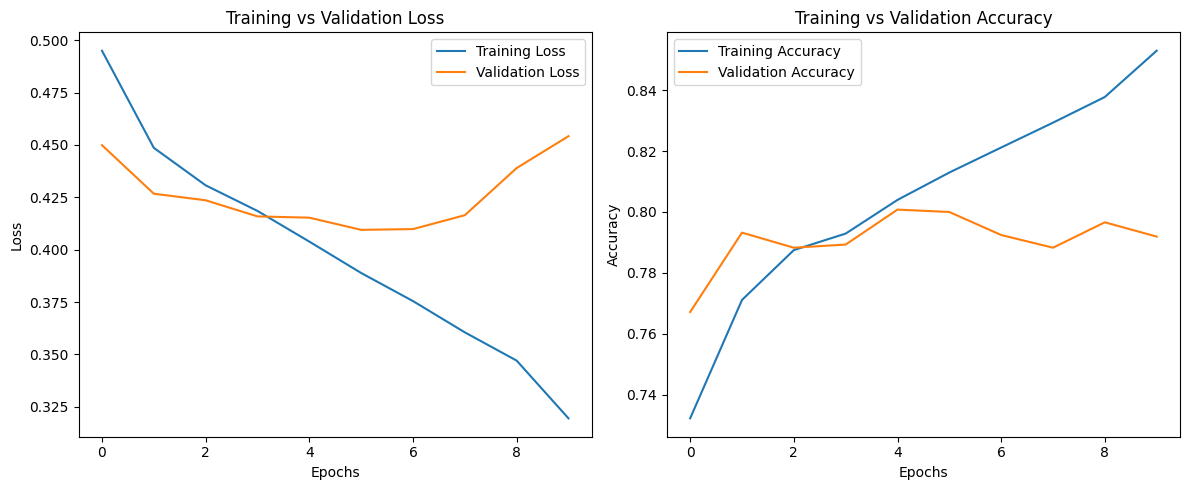

<ipython-input-27-142311dbdc1b>:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_vgg16_bert_model.pth'))



Evaluating model on test set...
Image not found for image_ (2994).jpg, using blank image
Image not found for meme_380.png, using blank image
Image not found for 18432.png, using blank image
Image not found for 68951.png, using blank image
Image not found for meme_208.png, using blank image
Image not found for Image_(817).jpg, using blank image
Image not found for Image_(2832).jpg, using blank image
Image not found for 47901.png, using blank image
Image not found for 97831.png, using blank image
Image not found for Image_(1858).jpg, using blank image
Image not found for 79386.png, using blank image
Image not found for 89732.png, using blank image
Image not found for 36578.png, using blank image
Image not found for Image_(5599).jpg, using blank image
Image not found for 09731.png, using blank image
Image not found for 80734.png, using blank image
Image not found for 51746.png, using blank image
Image not found for image_ (2190).jpg, using blank image
Image not found for image_ (111).jpg

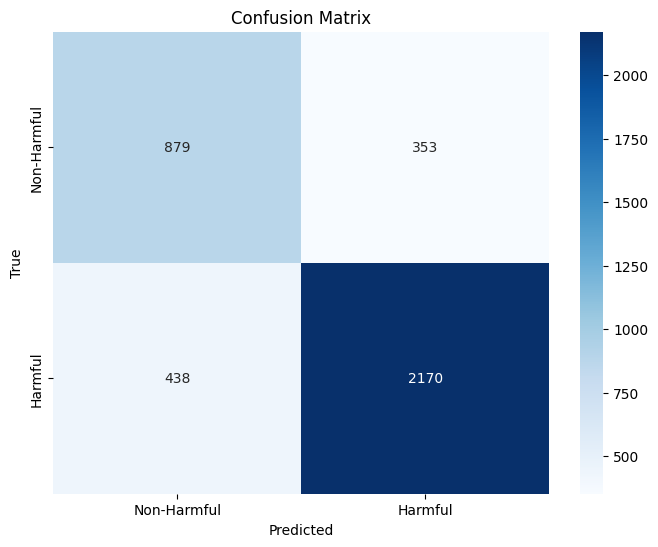

vgg16 model training and evaluation complete!


In [28]:
def inspect_dataset(df, image_dir):
    """
    Inspects the dataset and the image directory to understand the structure.
    """
    print("\n=== Dataset Inspection ===")
    print(f"Dataset columns: {df.columns.tolist()}")
    print(f"Number of rows: {len(df)}")
    print(f"Label distribution: {df['label'].value_counts().to_dict()}")
    
    # Check if image directory exists
    if not os.path.exists(image_dir):
        print(f"WARNING: Image directory does not exist: {image_dir}")
        return
    
    # Count image files
    image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f)) and 
                   f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]
    
    print(f"Number of image files in directory: {len(image_files)}")
    if len(image_files) > 0:
        print(f"Sample image filenames: {image_files[:5]}")
    
    # Check name column format
    print("\nSample names from dataset:")
    print(df['name'].head(5).tolist())
    
    # Check if any dataset names exactly match image filenames
    matching_names = [name for name in df['name'].unique() if name in image_files]
    print(f"Number of exact matches between 'name' column and image filenames: {len(matching_names)}")
    
    # Check if IDs are in the name column
    if 'id' in df.columns or 'ids' in df.columns:
        id_col = 'ids' if 'ids' in df.columns else 'id'
        print(f"\nSample values from '{id_col}' column:")
        print(df[id_col].head(5).tolist())
        
        # Check if IDs are in image filenames
        sample_ids = df[id_col].astype(str).head(5).tolist()
        for id_val in sample_ids:
            matches = [f for f in image_files if id_val in f]
            if matches:
                print(f"Found matches for ID {id_val}: {matches[:2]}")
                
    return image_files

if __name__ == "__main__":
    main()